In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os.path
import random

import tensorflow as tf
import tensorflow.keras as keras

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import exposure, filters, io, morphology, transform
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [15]:
try:
  ran == True

except:
  # path2 = kagglehub.dataset_download("alessiocorrado99/animals10")

  # print("Path to dataset files:", path)
  ran = True
else:
  print(path2)


path2


In [2]:
# # Download dataset from Kaggle using KaggleHub

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("alessiocorrado99/animals10")

# print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:26<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [2]:
# set the path to the dataset and the path to the images folder
# path = 'C:\\Users\\Natanael\\.cache\\kagglehub\\datasets\\alessiocorrado99\\animals10\\versions\\2\\raw-img'
path = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'
# path = path2
path

'/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'

In [3]:
# https://www.kaggle.com/code/vencerlanz09/animal-image-classification-using-efficientnetb7?scriptVersionId=125017960&cellId=11

def convert_path_to_df(dataset):
    """
    Convert image paths to a DataFrame

    Args:
        dataset: str, path to the dataset

    Returns:
        image_df: DataFrame, contains filepaths and labels

    """
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(path)

In [4]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
print("Done")

Done


,count
Label,
cane,4863
ragno,4819
gallina,3098
cavallo,2623
farfalla,2072
mucca,1866
scoiattolo,1862
pecora,1820
gatto,1667


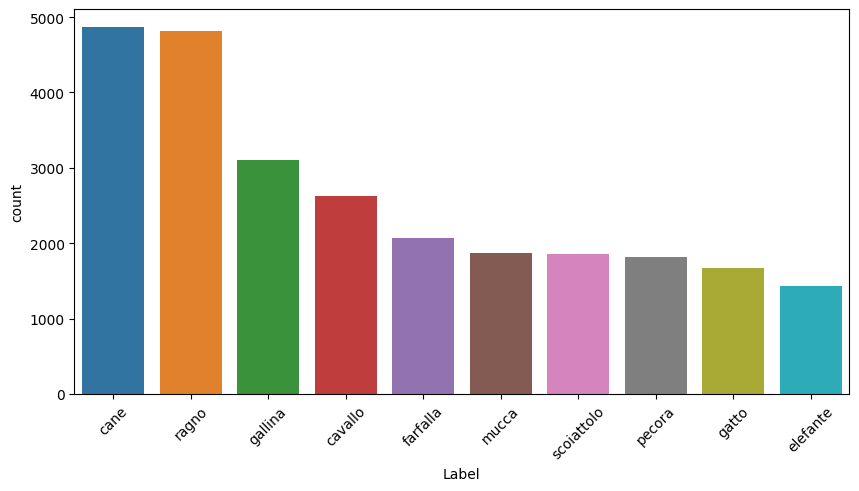

In [5]:
# Display the number of images per class
display(image_df.value_counts('Label'))

labels = image_df['Label'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=labels.index, y=labels, hue=labels.index )
plt.xticks(rotation=45)
plt.show()

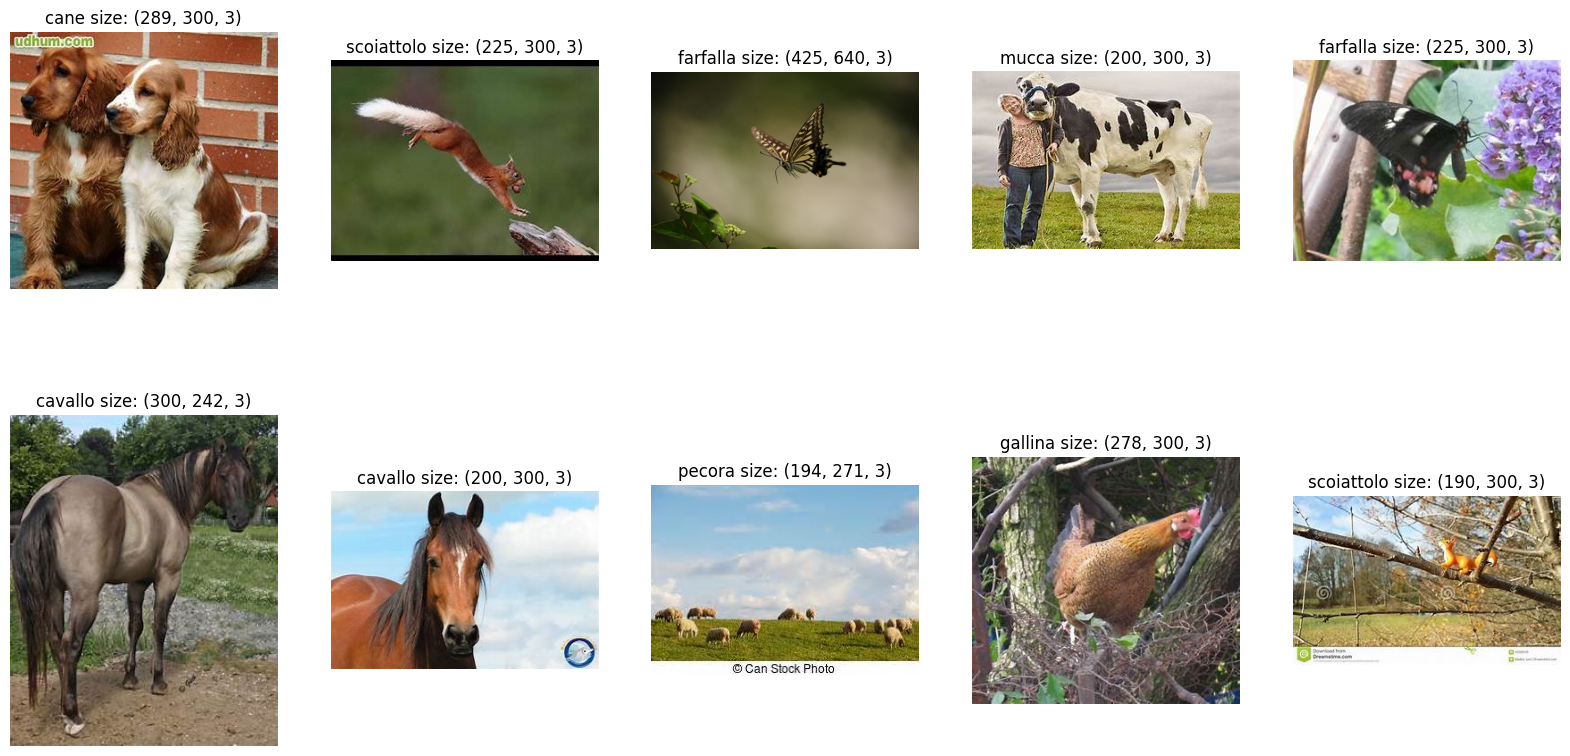

In [6]:
#  open 10 random images in image_df, with path in column 'Filepath', with respective labels and sizes
random.seed(42)
random_range = random.sample(range(0, len(image_df)), 10)
plt.figure(figsize=(20, 10))
for i in random_range:
    plt.subplot(2, 5, random_range.index(i)+1)
    img = io.imread(image_df['Filepath'][i])
    plt.title(f"{image_df['Label'][i]} size: {img.shape}")
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [9]:
# look for the smallest and largest image in the dataset
min_shape = (np.inf, np.inf)
max_shape = (0, 0)
total_shape = (0, 0)
for i in range(len(image_df)):
    img = io.imread(image_df['Filepath'][i])
    if img.shape[0] < min_shape[0]:
        min_shape = img.shape
    if img.shape[0] > max_shape[0]:
        max_shape = img.shape

print(f"Smallest image shape: {min_shape}")
print(f"Largest image shape: {max_shape}")


Smallest image shape: (57, 60, 3)
Largest image shape: (6000, 3798, 3)


In [7]:
# Define image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and preprocess images
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image

def full_preprocess(image_path):
  preprocessed_image = preprocess_image(image_path)
  preprocessed_image = datagen.flow(preprocessed_image, batch_size=1)[0]

  return preprocessed_image


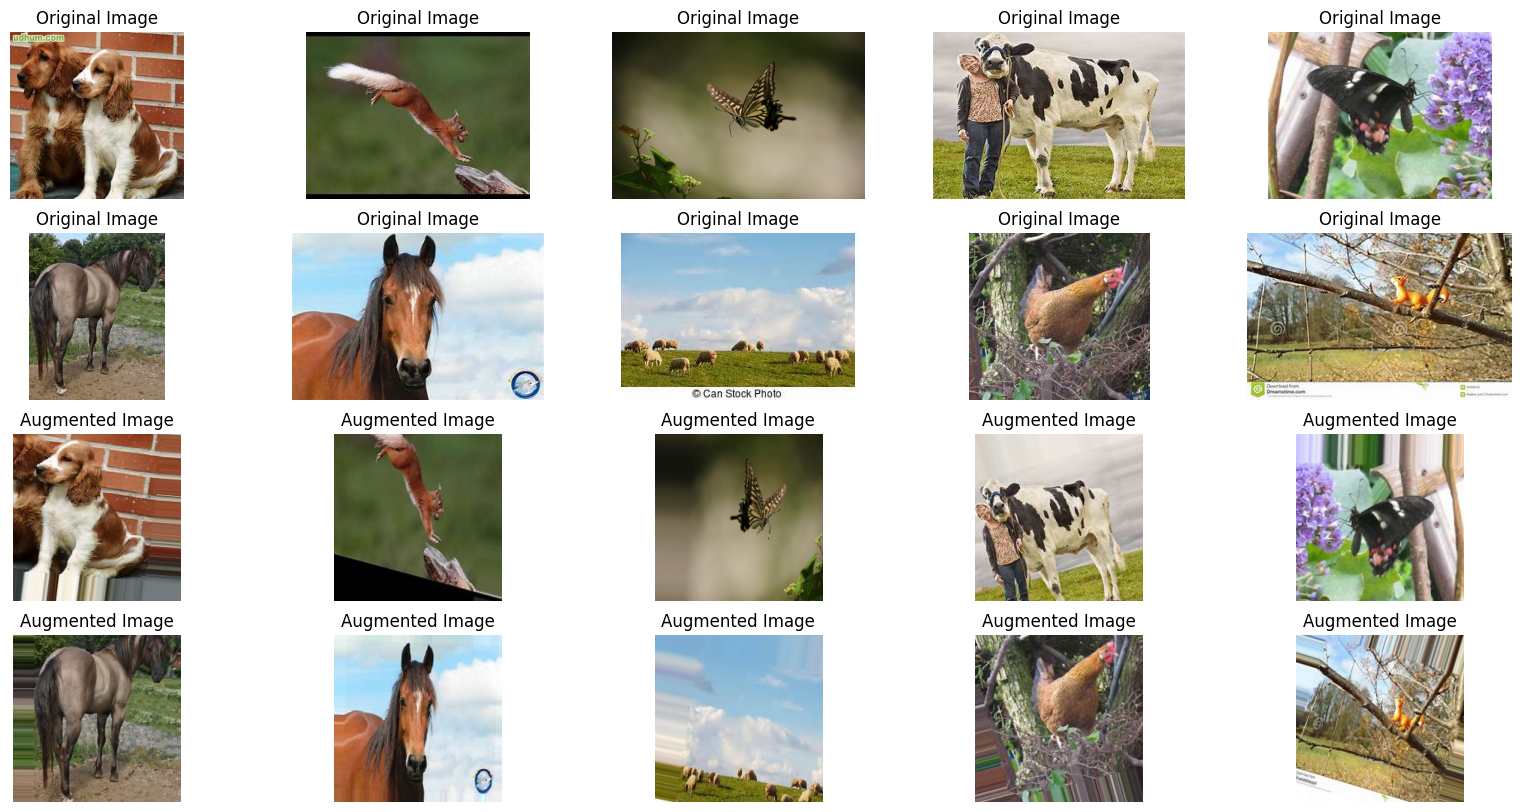

In [8]:
# Example usage
# random_range = random.sample(range(0, len(image_df)), 10)
plt.figure(figsize=(20, 10))
for i in random_range:
    image_path = image_df['Filepath'][i]
    preprocessed_image = preprocess_image(image_path)
    preprocessed_image = datagen.flow(preprocessed_image, batch_size=1)[0]

    plt.subplot(4, 5, random_range.index(i)+1)
    plt.title('Original Image')
    plt.imshow(io.imread(image_path))
    plt.axis('off')

    plt.subplot(4, 5, random_range.index(i)+11)
    plt.title('Augmented Image')
    plt.imshow(preprocessed_image[0])
    plt.axis('off')

plt.show()

## separating data

In [9]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [10]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # validation_split=0.2  # Use 20% of data for validation
)

# Only rescaling for validation and test data
valid_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # validation_split=0.2  # Use 20% of data for validation
    )

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    # batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    # subset='training',
    color_mode='rgb'
)

validation_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    # subset='validation',
    color_mode='rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 16721 validated image filenames belonging to 10 classes.
Found 4181 validated image filenames belonging to 10 classes.
Found 5226 validated image filenames belonging to 10 classes.


## CNN

In [38]:
# create a cnn model for image classification (10 classes)
def create_model():
    model = models.Sequential()
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [47]:
def model2():
  model = models.Sequential()
  model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu")),
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu")),

  model.add(layers.MaxPooling2D(pool_size=(2, 2))),

  model.add(layers.Flatten()),
  model.add(layers.Dropout(0.5)),

  model.add(layers.Dense(10, activation="softmax"))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model


In [48]:
cnn = model2()
cnn.summary()
BATCH_SIZE = 64
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    batch_size = BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint],
    verbose = 1
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 51, 51, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │         400,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 502,506 (1.92 MB)

 Trainable params: 502,506 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
523/523 ━━━━━━━━━━━━━━━━━━━━ 287s 441ms/step - accuracy: 0.2078 - loss: 2.1769 - val_accuracy: 0.3497 - val_loss: 1.9192
Epoch 2/3
523/523 ━━━━━━━━━━━━━━━━━━━━ 218s 413ms/step - accuracy: 0.3284 - loss: 1.9026 - val_accuracy: 0.4463 - val_loss: 1.5827
Epoch 3/3
523/523 ━━━━━━━━━━━━━━━━━━━━ 217s 410ms/step - accuracy: 0.4080 - loss: 1.6705 - val_accuracy: 0.5338 - val_loss: 1.3932


In [12]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# sns.set_style('darkgrid')

In [13]:
augment = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [14]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    # steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    # validation_steps=len(validation_generator),
    epochs=3,
    verbose = 1,
    callbacks=[
        early_stopping,
        # create_tensorboard_callback("training_logs",
        #                             "animals_classification"),
        # checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


523/523 ━━━━━━━━━━━━━━━━━━━━ 439s 671ms/step - accuracy: 0.1034 - loss: 3.3627 - val_accuracy: 0.0739 - val_loss: 2.6094 - learning_rate: 1.0000e-05
Epoch 2/3
523/523 ━━━━━━━━━━━━━━━━━━━━ 279s 525ms/step - accuracy: 0.0962 - loss: 3.2390 - val_accuracy: 0.0715 - val_loss: 2.5403 - learning_rate: 1.0000e-05
Epoch 3/3
 87/523 ━━━━━━━━━━━━━━━━━━━━ 3:22 464ms/step - accuracy: 0.0961 - loss: 3.1524

KeyboardInterrupt: 